# Photon response

This notebook builds up on the output of the [HGCDigiTester](https://github.com/PFCal-dev/HGCElectronicsValidation/blob/master/src/HGCDigiTester.cc) tool.

In [4]:
import ROOT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#convert trees to dataframes and pre-select them
df={}
for tag,url in [('aged','/eos/cms/store/cmst3/user/psilva/HGCAL/digi_closure.root'),
                ('startup','/eos/cms/store/cmst3/user/psilva/HGCAL/digi_closure_startup.root')]:

    fIn=ROOT.TFile.Open(url)
    t=fIn.Get('ana/hits')
    rdf=ROOT.RDataFrame(t)
    df[tag]=pd.DataFrame(rdf.AsNumpy())
    fIn.Close()

    df[tag]['side']=np.where(df[tag]['z']<0,-1,1)
    mask = (df[tag]['mipsim']>1.0) & (abs(df[tag]['geta'])>1.5) & (abs(df[tag]['geta'])<3)
    df[tag] = df[tag][mask]
    print(tag,'has',df[tag].shape[0],'hits to analyze from',len(df[tag]['event'].unique()),'events')

aged has 2932985 hits to analyze from 987 events
startup has 2913564 hits to analyze from 1000 events


## Apply de/dx layer weights

The weights are used to scale the MIP multiplicity in each layer and are directly retrieved from [HGCalRecHit_cfi.py](https://github.com/cms-sw/cmssw/blob/master/RecoLocalCalo/HGCalRecProducers/python/HGCalRecHit_cfi.py)

In [5]:
dedx_wgt=[0.0, 8.894541, 10.937907, 10.937907, 10.937907, 10.937907, 10.937907, 10.937907, 10.937907, 10.937907, 
         10.932882, 10.932882, 10.937907, 10.937907, 10.938169,10.938169, 10.938169, 10.938169, 10.938169, 10.938169, 
         10.938169, 10.938169, 10.938169, 10.938169, 10.938169,10.938169, 10.938169, 10.938169, 32.332097, 51.574301, 
         51.444192, 51.444192, 51.444192, 51.444192, 51.444192,51.444192, 51.444192, 51.444192, 51.444192, 51.444192, 
         69.513118, 87.582044, 87.582044, 87.582044, 87.582044, 87.582044, 87.214571, 86.888309, 86.92952, 86.92952, 
         86.92952]
    
def apply_dedx(x,cols=['miprec','mipsim']):   
    lay=int(x['layer'])
    return [ x[c]*dedx_wgt[lay] for c in cols ]

for tag in df:
    print('Applying de/dx weights for',tag)
    df[tag]['miprec_w'], df[tag]['mipsim_w'] = zip(*df[tag][['layer','miprec','mipsim']].apply(apply_dedx,axis=1))

Applying de/dx weights for aged
Applying de/dx weights for startup


## Apply charge collection efficiency correction and build the total energy per shower

The CCE is stored in the ntuples per pad. It needs to be applied to the aged scenario to correct for radiation effects.
To sum the total energy per shower we index the data using (event,side), assuming one particle in each endcap, and sum up the energy estimators.

In [23]:
shower_data={}
for tag in df:
    
    #correct for CCE if needed
    if tag=='startup':
        df[tag]['cor_miprec_w']=df[tag]['miprec_w']
    else:
        df[tag]['cor_miprec_w']=df[tag]['miprec_w']/df[tag]['cce']
    
    #index and summarize per shower
    df_indexed=df[tag].set_index(['event','side'])
    level=[0,1]
    shower_desc = { 'genergy'           : df_indexed.mean(level=level)['genergy'],
                    'geta'              : df_indexed.mean(level=level)['geta'],
                    'thick'             : df_indexed.mean(level=level)['thick'],
                    'total_mipsim_w'    : df_indexed.sum(level=level)['mipsim_w'],
                    'total_miprec_w'    : df_indexed.sum(level=level)['miprec_w'],
                    'total_cor_miprec_w': df_indexed.sum(level=level)['cor_miprec_w'],
                  }
    shower_data[tag] = pd.DataFrame(shower_desc)
    shower_data[tag].reset_index(inplace=True)
    print('Collected',shower_data[tag].shape[0],'showers for',tag)

Collected 1974 showers for aged
Collected 1999 showers for startup


## Summary plots

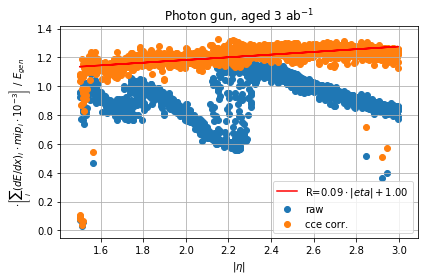

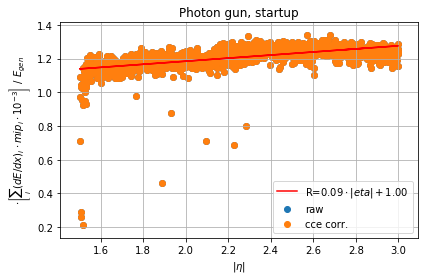

In [7]:
for tag in shower_data:
    
    summary=shower_data[tag]
    
    #fit the average reponse
    x    = abs(summary['geta'])
    y    = 1e-3*summary['total_miprec_w']/summary['genergy']
    ycor = 1e-3*summary['total_cor_miprec_w']/summary['genergy']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,ycor)
    yexp = slope*x+intercept
    
    plt.scatter(x,y,label='raw')
    plt.scatter(x,ycor,label='cce corr.')
    plt.plot(x,yexp,'r',label=r'R=${:3.2f}\cdot|eta|+{:3.2f}$'.format(slope,intercept))
    plt.xlabel(r'$|\eta|$')
    plt.ylabel(r'$\cdot\left[ \sum_{i} (dE/dx)_{i} \cdot mip_i \cdot 10^{-3} \right]~/~E_{gen}$')
    plt.grid()
    plt.legend(loc='best')
    title=r'Photon gun, aged 3 ab$^{-1}$'
    if tag=='startup': title=r'Photon gun, startup'
    plt.title(title)
    plt.tight_layout()
    plt.show()

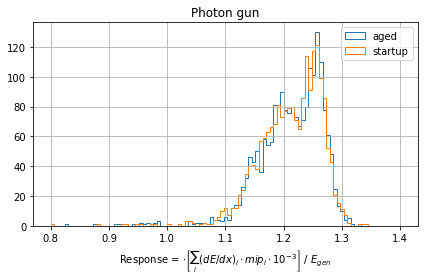

In [10]:
for tag in shower_data:
    
    summary=shower_data[tag]
    x = 1e-3*summary['total_cor_miprec_w']/summary['genergy']
    bins=np.linspace(0.8,1.4,100)
    plt.hist(x,label=tag,histtype='step',bins=bins)

plt.xlabel(r'Response = $\cdot\left[ \sum_{i} (dE/dx)_{i} \cdot mip_i \cdot 10^{-3} \right]~/~E_{gen}$')
plt.grid()
plt.legend(loc='best')
plt.title('Photon gun')
plt.tight_layout()
plt.show()

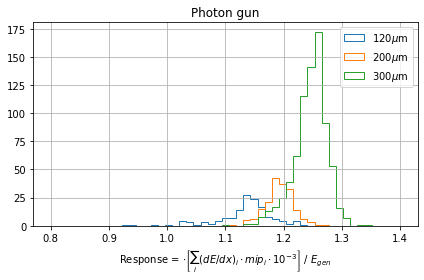

In [27]:
summary=shower_data['startup'].copy()
bins=np.linspace(0.8,1.4,50)
for label,mask in [('120$\mu$m',abs(summary['thick']-2)<0.01),
                   ('200$\mu$m',abs(summary['thick']-1)<0.01),
                   ('300$\mu$m',abs(summary['thick']-0)<0.01),
                  ]:

    x = 1e-3*summary[mask]['total_cor_miprec_w']/summary[mask]['genergy']
    plt.hist(x,bins=bins,label=label,histtype='step')


plt.xlabel(r'Response = $\cdot\left[ \sum_{i} (dE/dx)_{i} \cdot mip_i \cdot 10^{-3} \right]~/~E_{gen}$')
plt.grid()
plt.legend(loc='best')
plt.title('Photon gun')
plt.tight_layout()
plt.show()
